In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tqdm import tqdm
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import numpy as np
from pysentimiento.preprocessing import preprocess_tweet

In [2]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
MODEL_NAME = "finiteautomata/beto-emotion-analysis"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME).to(device)
model.eval()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31006, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [4]:
EMO_LABELS = list(model.config.id2label.values())
EMO_LABELS_PLOT = [emo for emo in EMO_LABELS if emo.lower() != "others"]


In [5]:
COLORS = {
    'joy': '#FFD700', 'sadness': '#1E90FF', 'anger': '#DC143C',
    'fear': '#8B008B', 'disgust': '#228B22', 'surprise': '#FF8C00'
}

In [6]:
hitos = [
    ("Estallido social", "2019-10-18"),
    ("Acuerdo por la Paz", "2019-11-15"),
    ("COVID: Estado Excepción", "2020-03-18"),
    ("Plebiscito Entrada", "2020-10-27"),
    ("Elección Constituyentes", "2021-05-16"),
    ("Inicio Convención", "2021-07-04"),
    ("Discusión Temática", "2021-10-18"),
    ("Inicio Plenos", "2022-02-15"),
    ("Inicio Comisiones Finales", "2022-04-29"),
    ("Entrega Borrador", "2022-07-04"),
    ("Plebiscito Salida 1", "2022-09-04"),
    ("Bases Segundo Proceso", "2022-12-12"),
    ("Expertos designados", "2023-01-24"),
    ("Inicio Comisión Experta", "2023-03-06"),
    ("Elección Consejeros", "2023-05-07"),
    ("Fin Anteproyecto", "2023-05-30"),
    ("Inicio Consejo Constitucional", "2023-06-07"),
    ("Cierre Consejo", "2023-11-07"),
    ("Plebiscito Salida 2", "2023-12-17")
]


In [7]:
def detectar_emocion_larga(texto, max_tokens=512):
    texto = preprocess_tweet(texto)
    palabras = texto.split()
    bloques = [' '.join(palabras[i:i + max_tokens]) for i in range(0, len(palabras), max_tokens)]

    scores_acumulados = torch.zeros(len(EMO_LABELS)).to(device)

    with torch.no_grad():
        for chunk in bloques:
            tokens = tokenizer(chunk, return_tensors="pt", padding=True, truncation=True).to(device)
            output = model(**tokens)
            probs = torch.nn.functional.softmax(output.logits, dim=1)
            scores_acumulados += probs[0]

    scores_normalizados = scores_acumulados / scores_acumulados.sum()
    emocion_index = torch.argmax(scores_normalizados).item()
    return EMO_LABELS[emocion_index]


In [9]:
df = pd.read_parquet("Database/01_bbdd_think_tanks_no_stopwords.parquet")
df = df[df["Texto"].notnull() & df["Think Tank"].notnull()]
df["FechaPublicacion"] = pd.to_datetime(df["FechaPublicacion"], errors="coerce")
df = df[df["FechaPublicacion"].notnull()]
df = df[(df["FechaPublicacion"] >= "2019-01-01") & (df["FechaPublicacion"] <= "2023-12-31")]
df["FechaMes"] = df["FechaPublicacion"].dt.to_period("M").dt.to_timestamp()


Procesando: LyD


Detectando emociones en LyD: 100%|██████████| 2623/2623 [01:49<00:00, 23.85it/s]


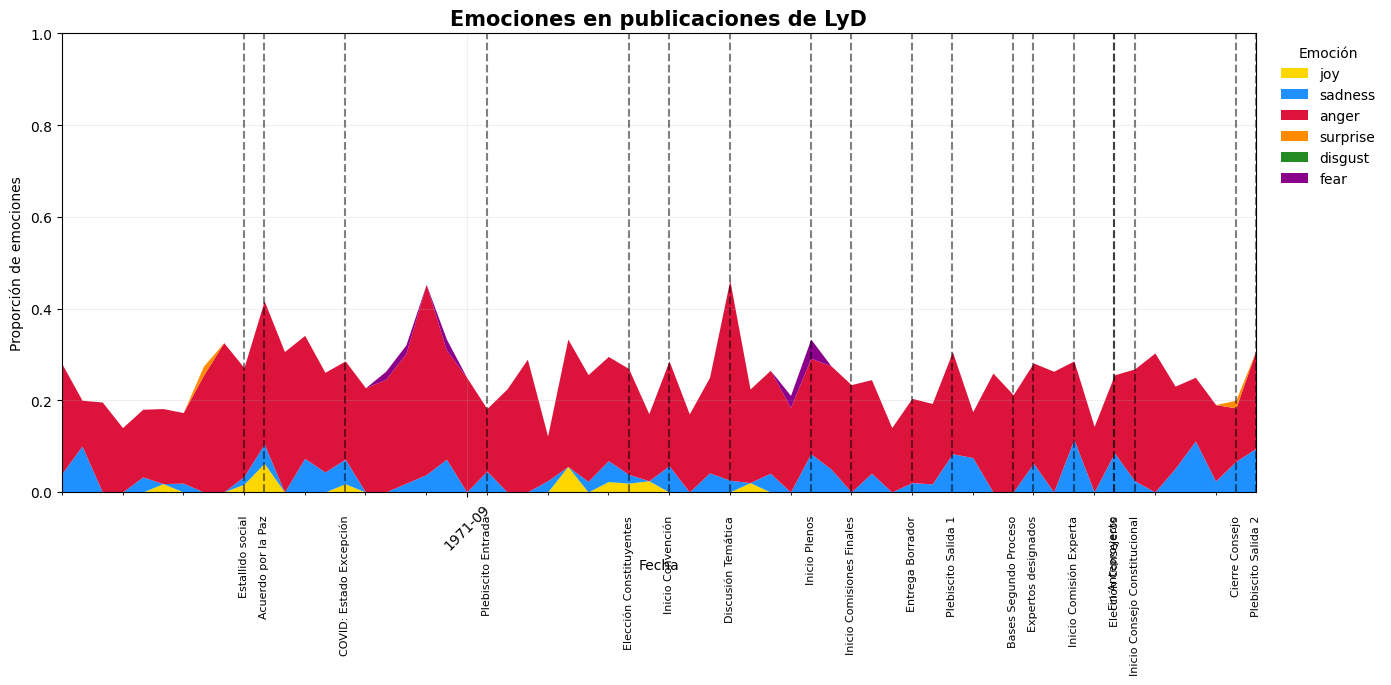

Procesando: CEP


Detectando emociones en CEP: 100%|██████████| 2008/2008 [01:25<00:00, 23.58it/s]


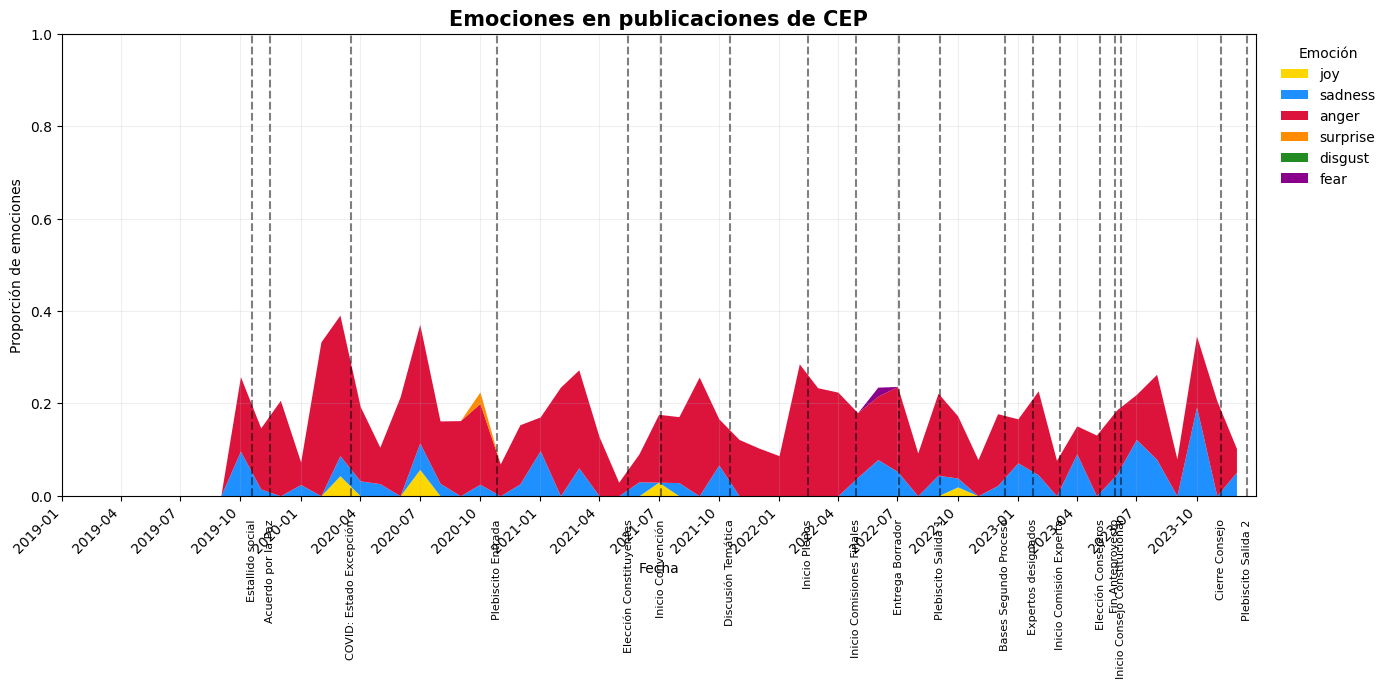

Procesando: Chile 21


Detectando emociones en Chile 21: 100%|██████████| 288/288 [00:10<00:00, 26.56it/s]


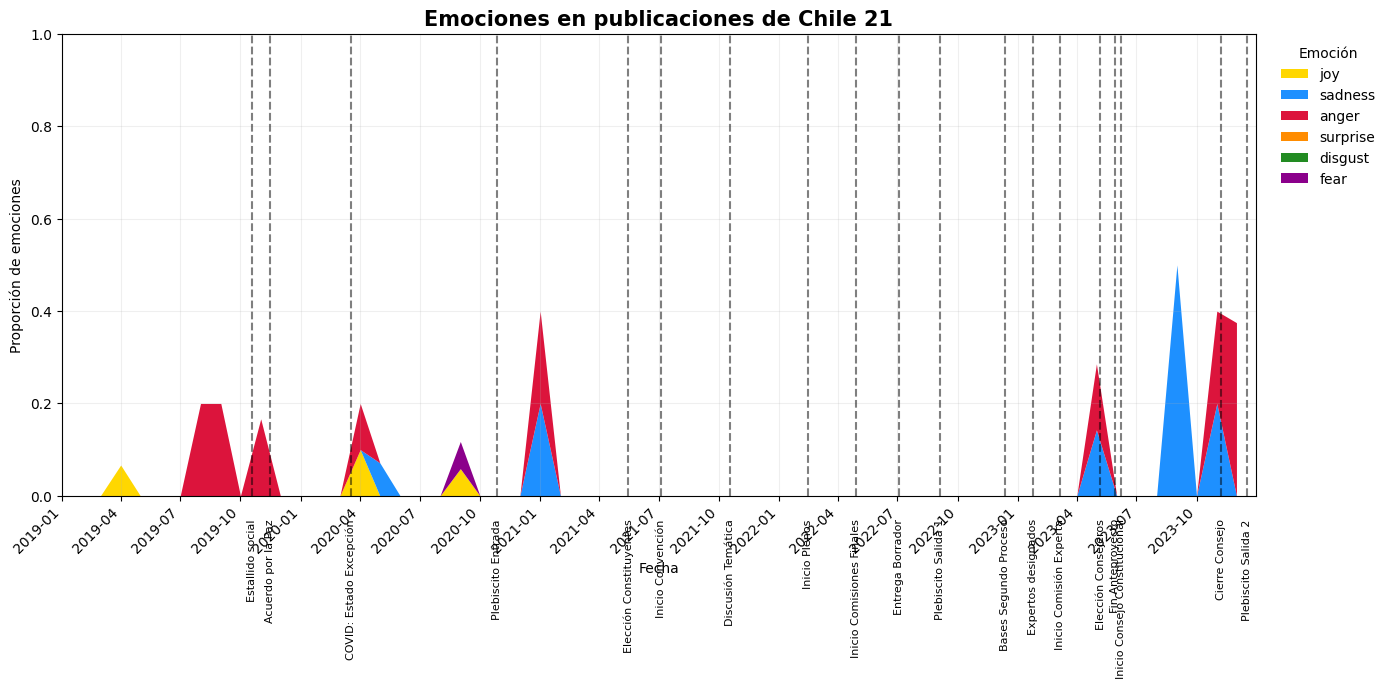

Procesando: Espacio Público


Detectando emociones en Espacio Público: 100%|██████████| 1525/1525 [00:48<00:00, 31.63it/s]


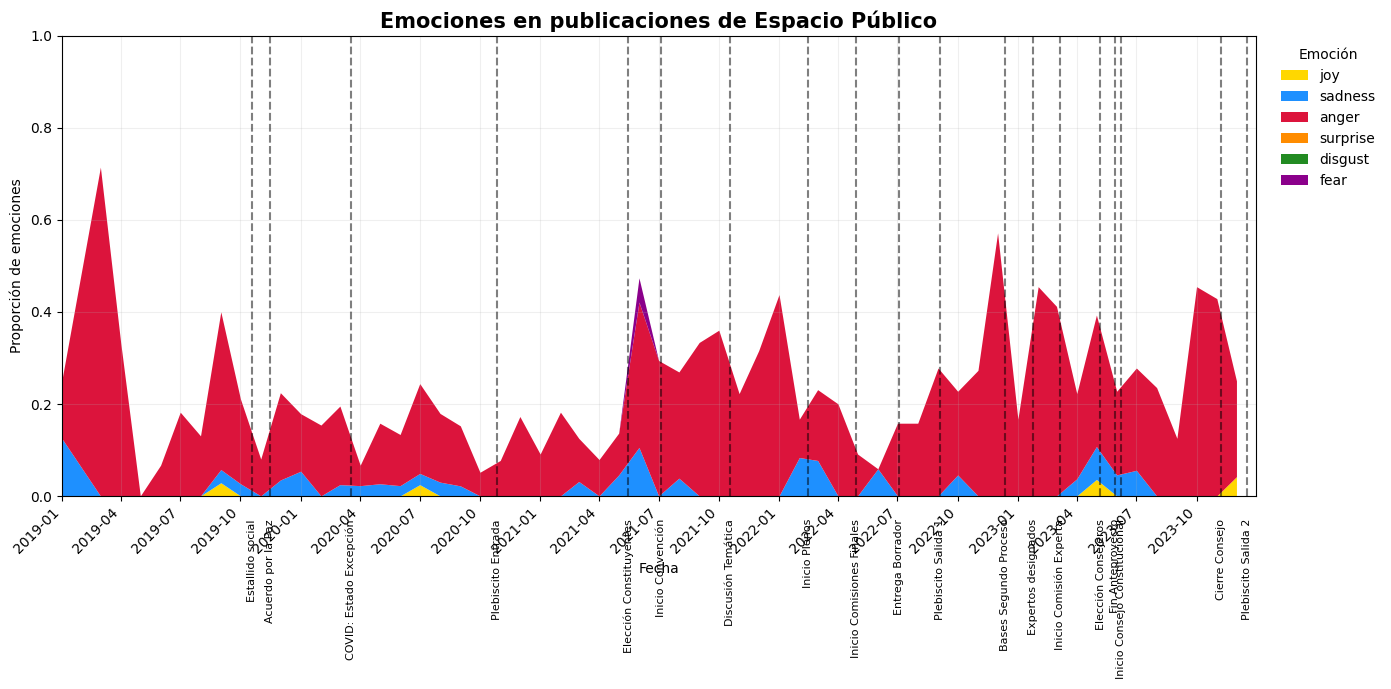

Procesando: Fundación Sol


Detectando emociones en Fundación Sol: 100%|██████████| 550/550 [00:26<00:00, 20.46it/s]


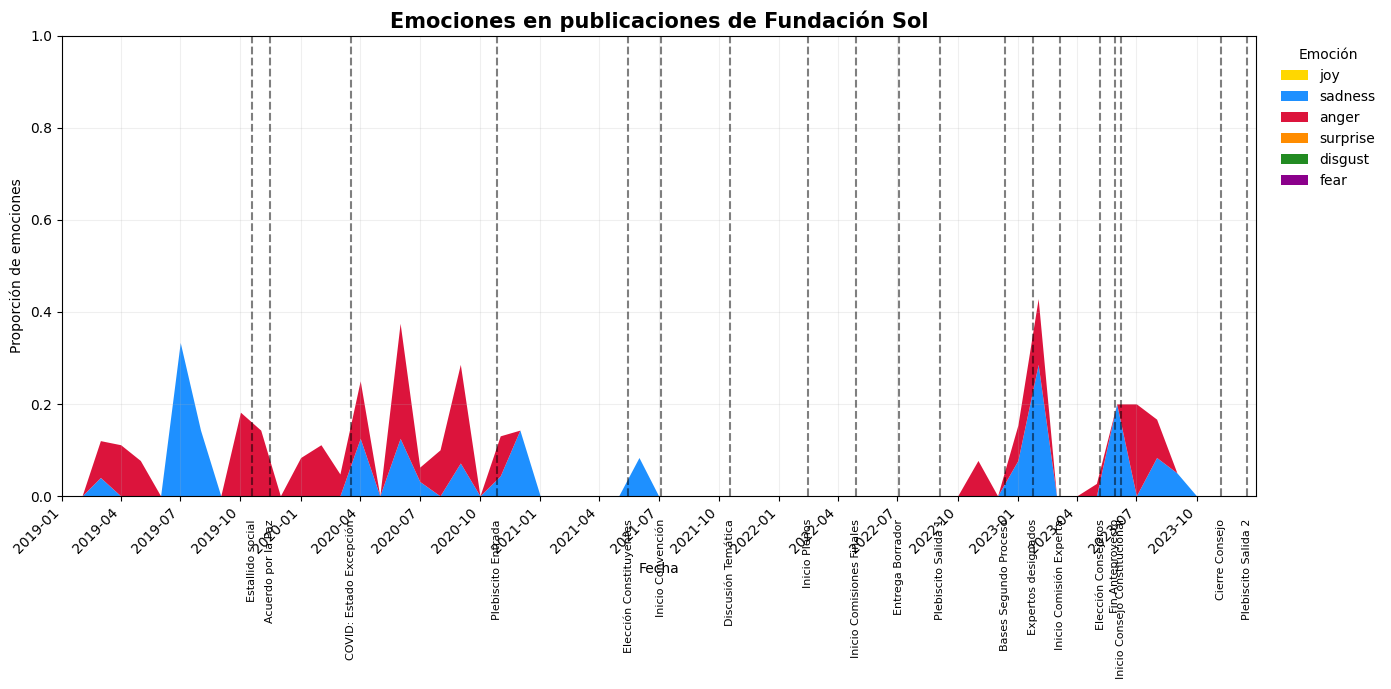

Procesando: IES


Detectando emociones en IES: 100%|██████████| 20/20 [00:06<00:00,  3.14it/s]


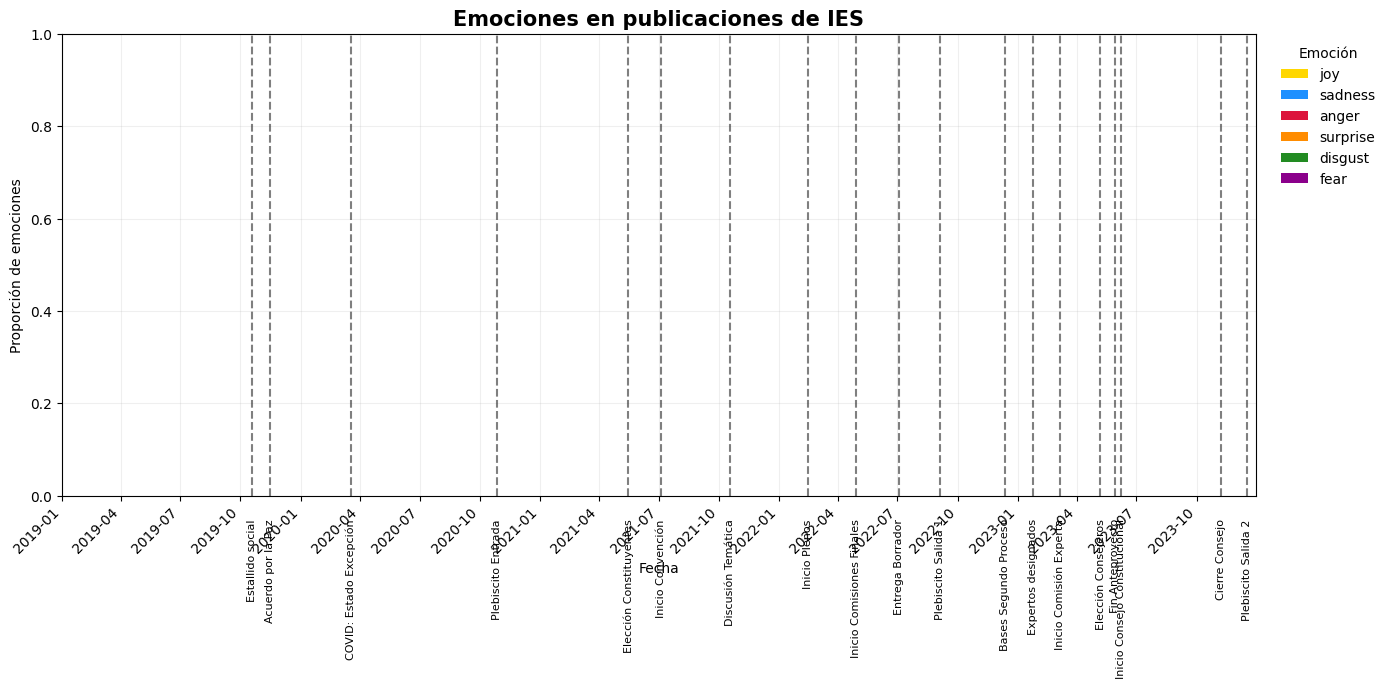

Procesando: Nodo XXI


Detectando emociones en Nodo XXI: 100%|██████████| 328/328 [00:20<00:00, 16.37it/s]


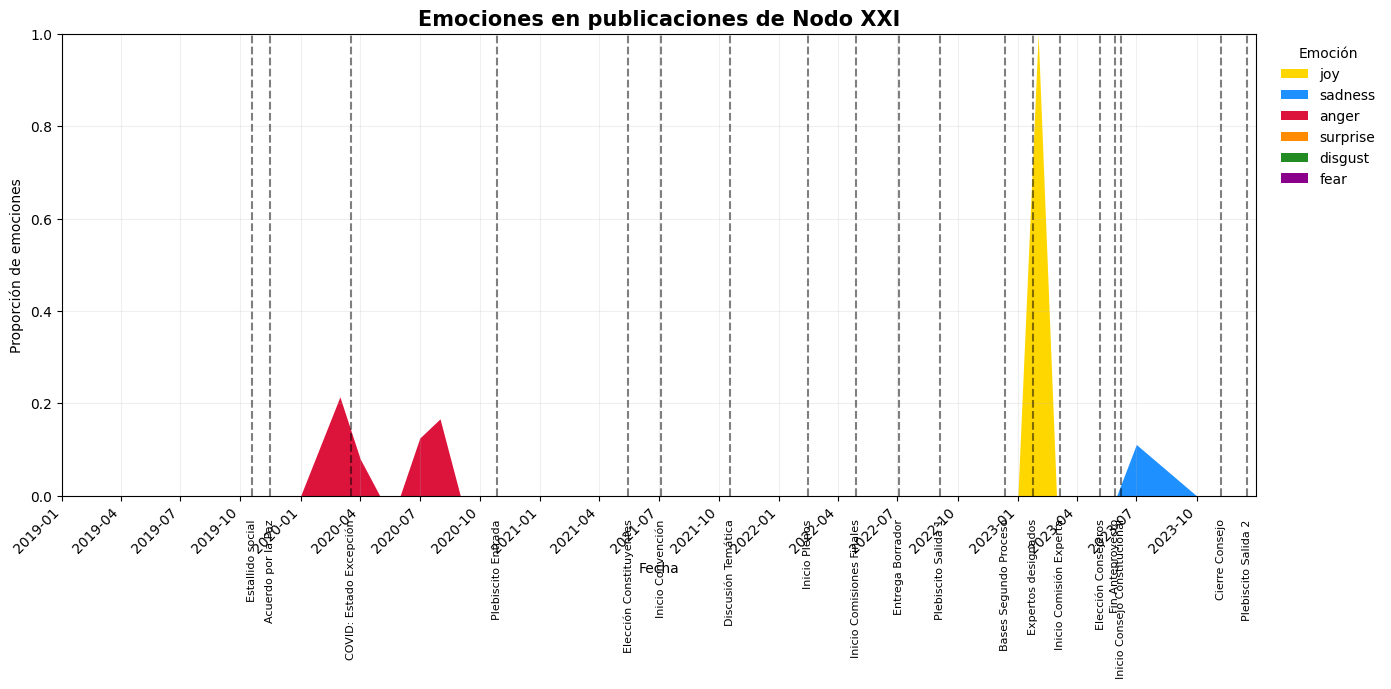

Procesando: OPES


Detectando emociones en OPES: 100%|██████████| 45/45 [00:01<00:00, 27.02it/s]


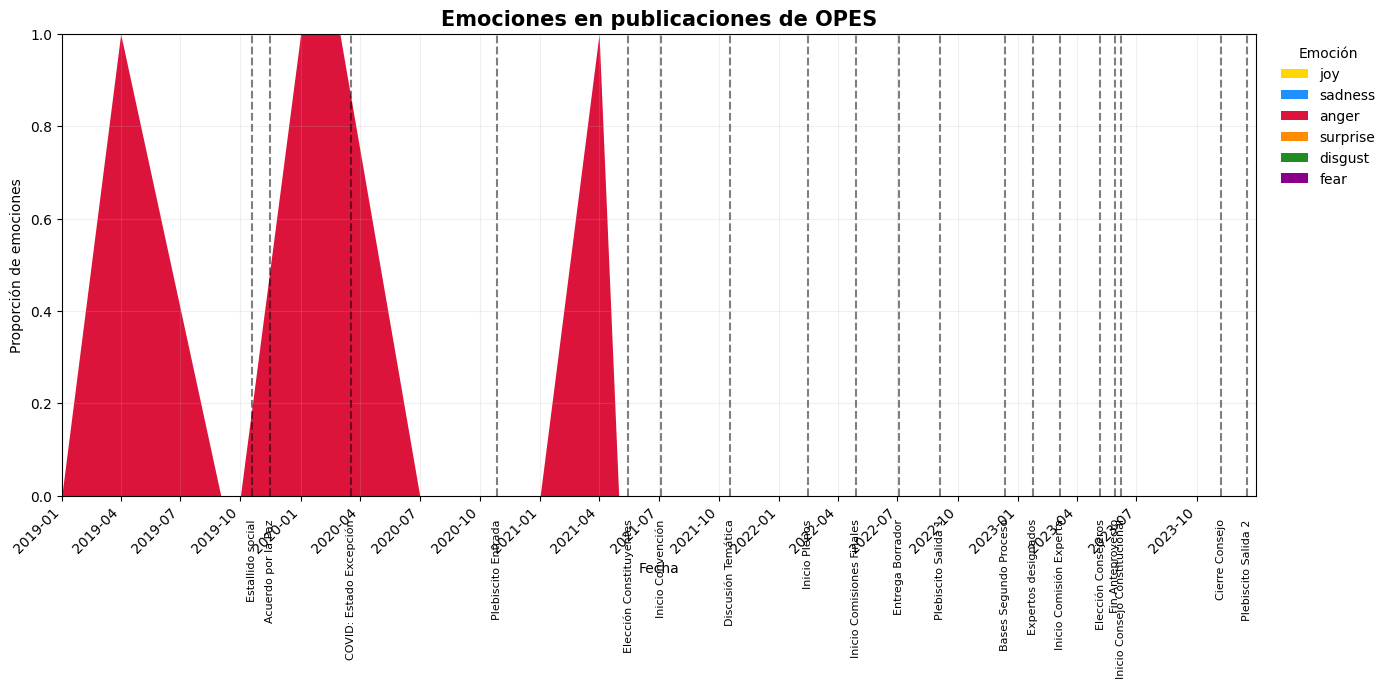

Procesando: Instituto Igualdad


Detectando emociones en Instituto Igualdad: 100%|██████████| 892/892 [00:34<00:00, 26.10it/s]


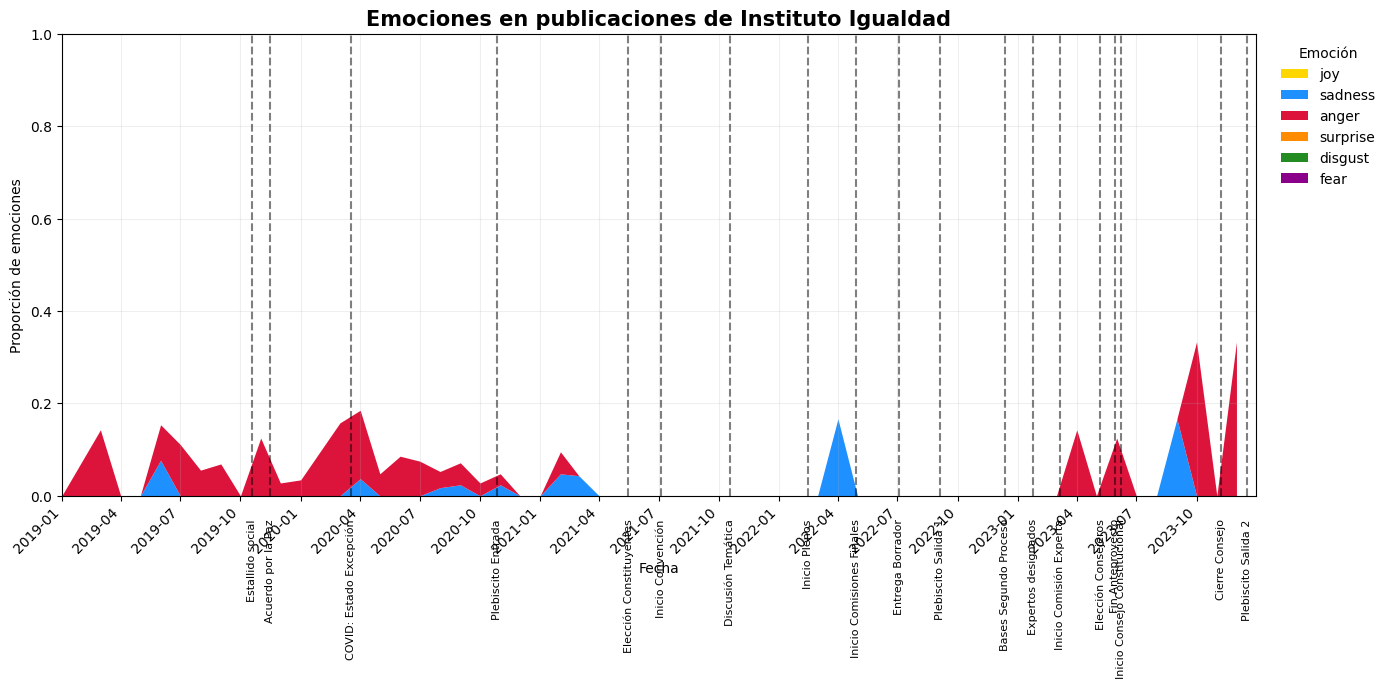

Procesando: ICAL


Detectando emociones en ICAL: 100%|██████████| 38/38 [00:02<00:00, 13.94it/s]


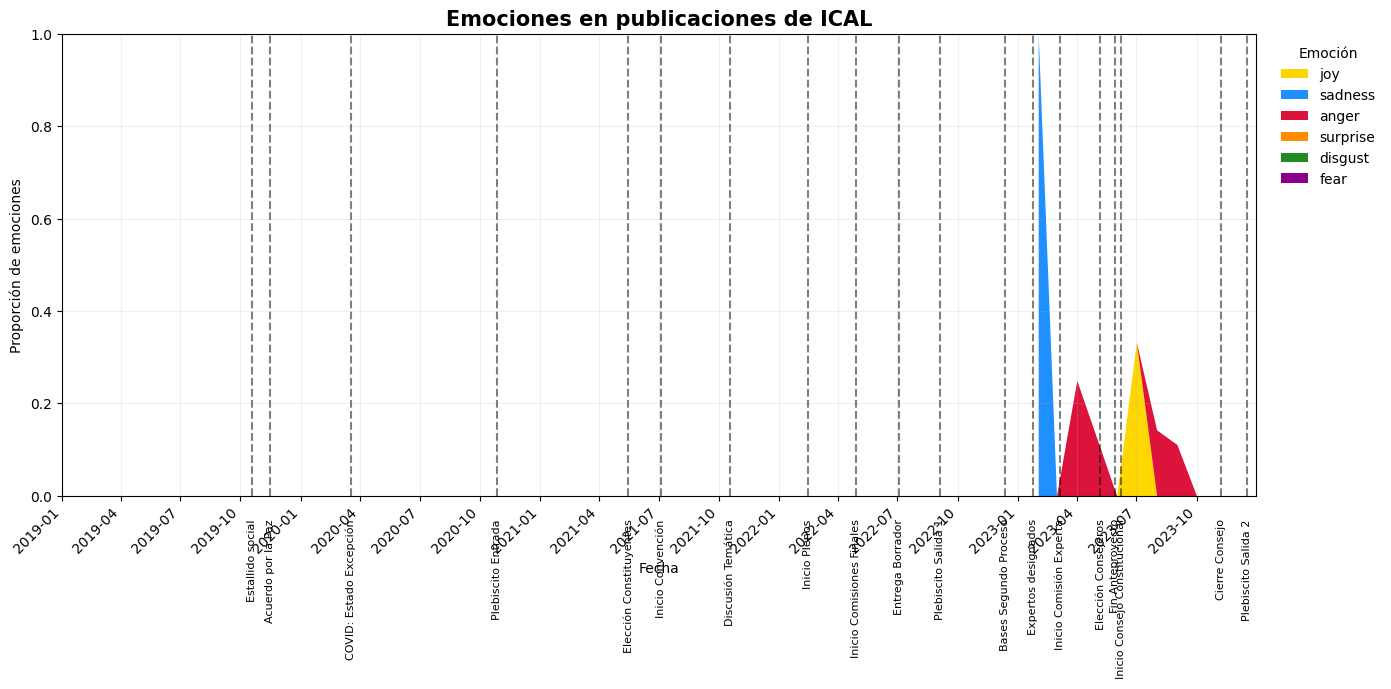

Procesando: Horizonte Ciudadano


Detectando emociones en Horizonte Ciudadano: 100%|██████████| 130/130 [00:05<00:00, 24.38it/s]


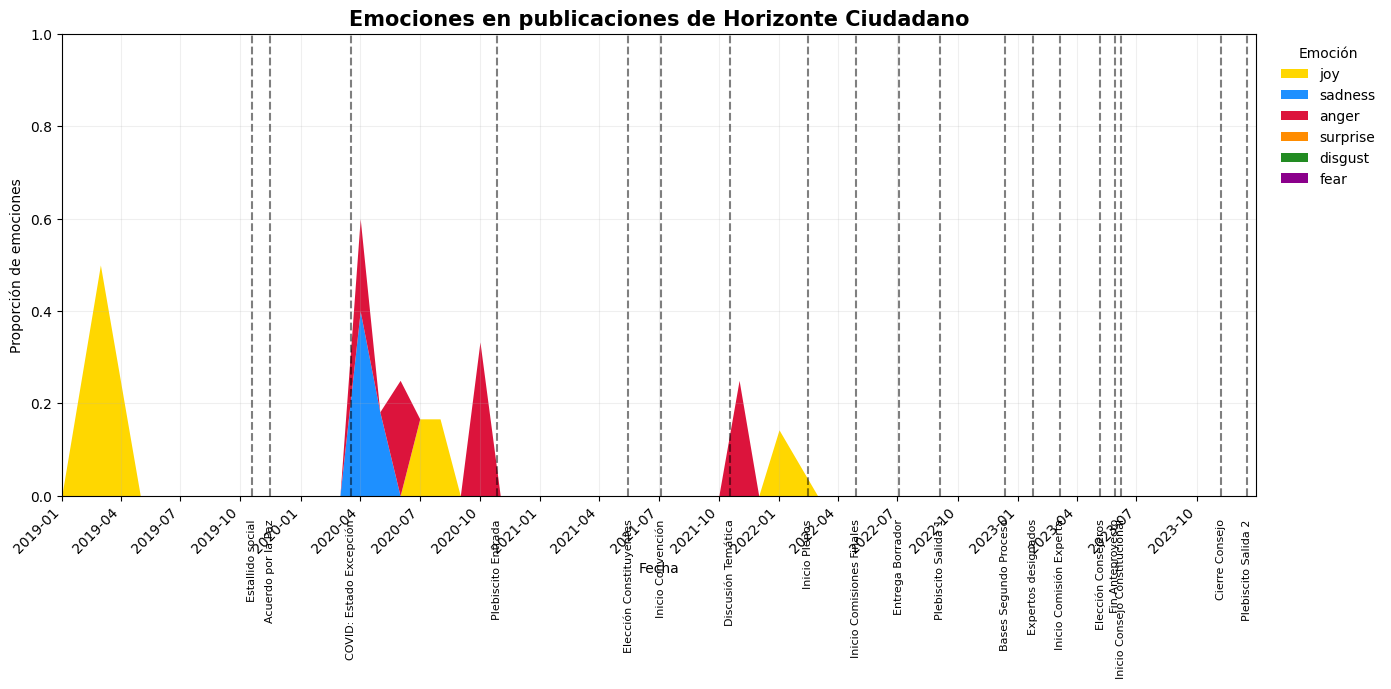

Procesando: CED


Detectando emociones en CED: 100%|██████████| 265/265 [00:09<00:00, 28.61it/s]


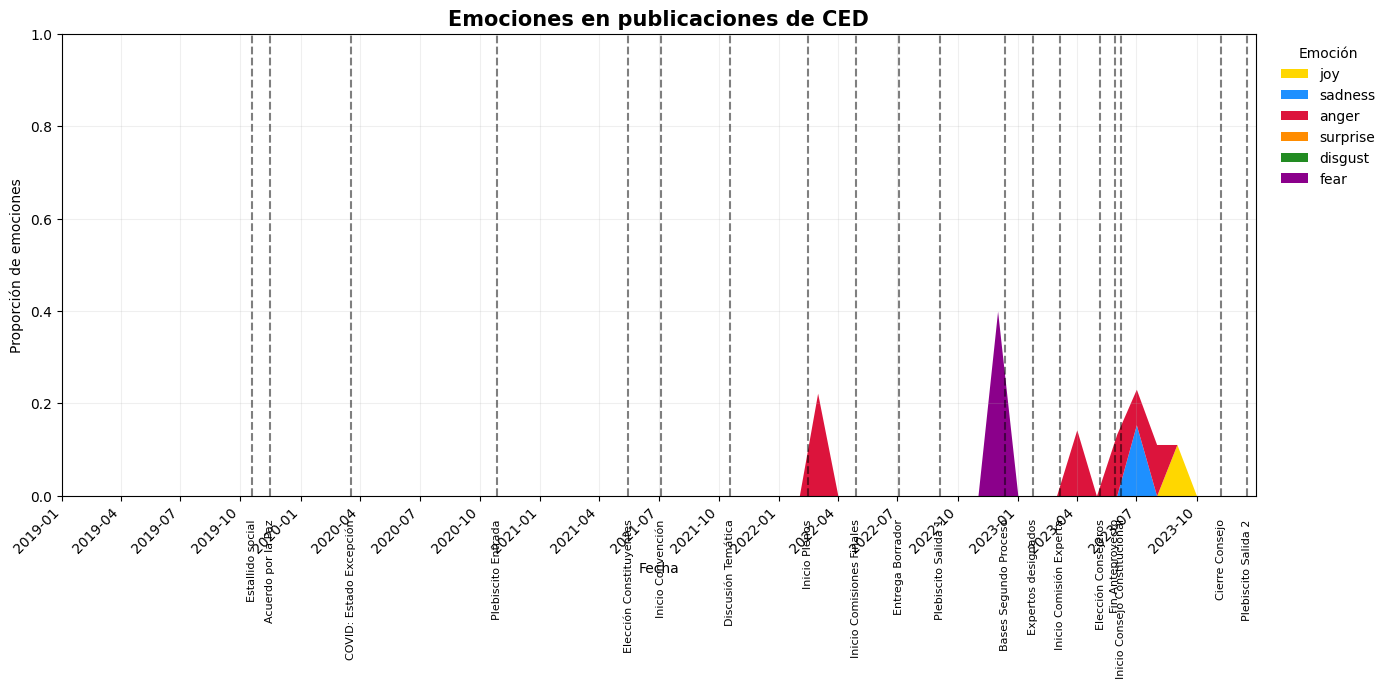

Procesando: CDC


Detectando emociones en CDC: 100%|██████████| 171/171 [00:39<00:00,  4.36it/s]


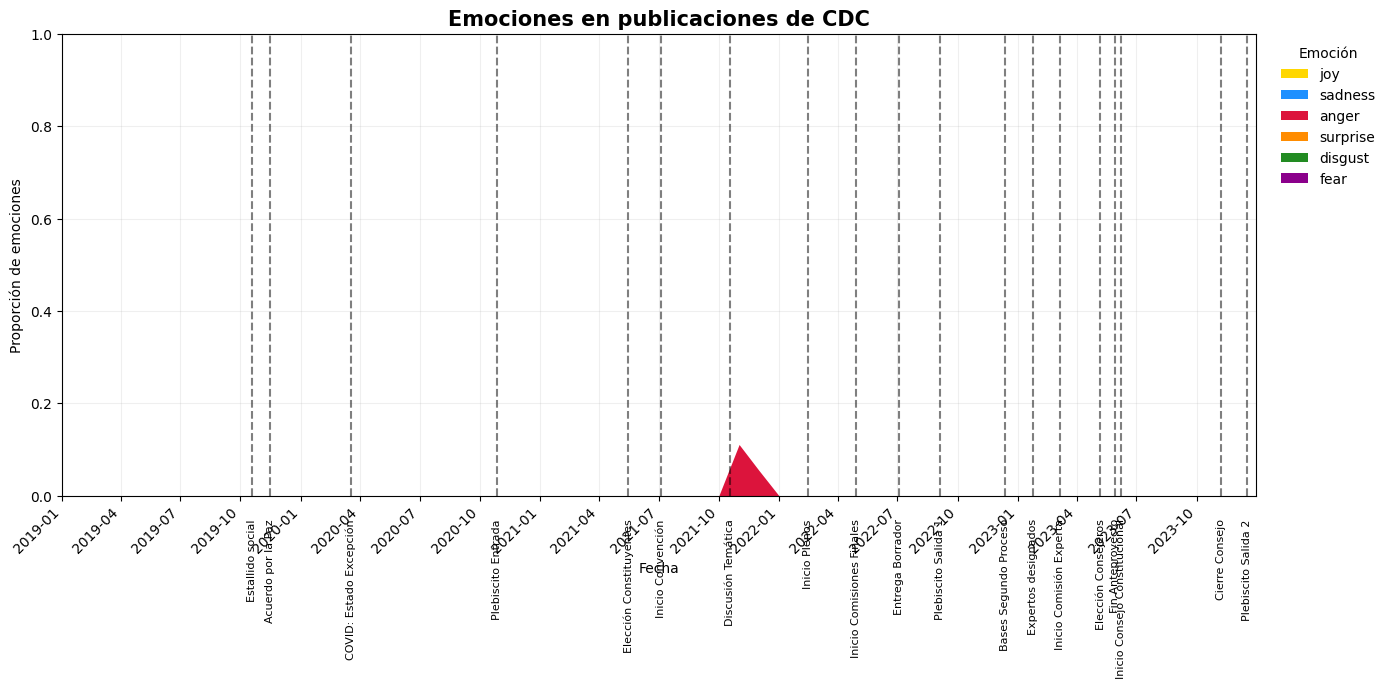

Procesando: Casa Común


Detectando emociones en Casa Común: 100%|██████████| 227/227 [00:11<00:00, 20.27it/s]


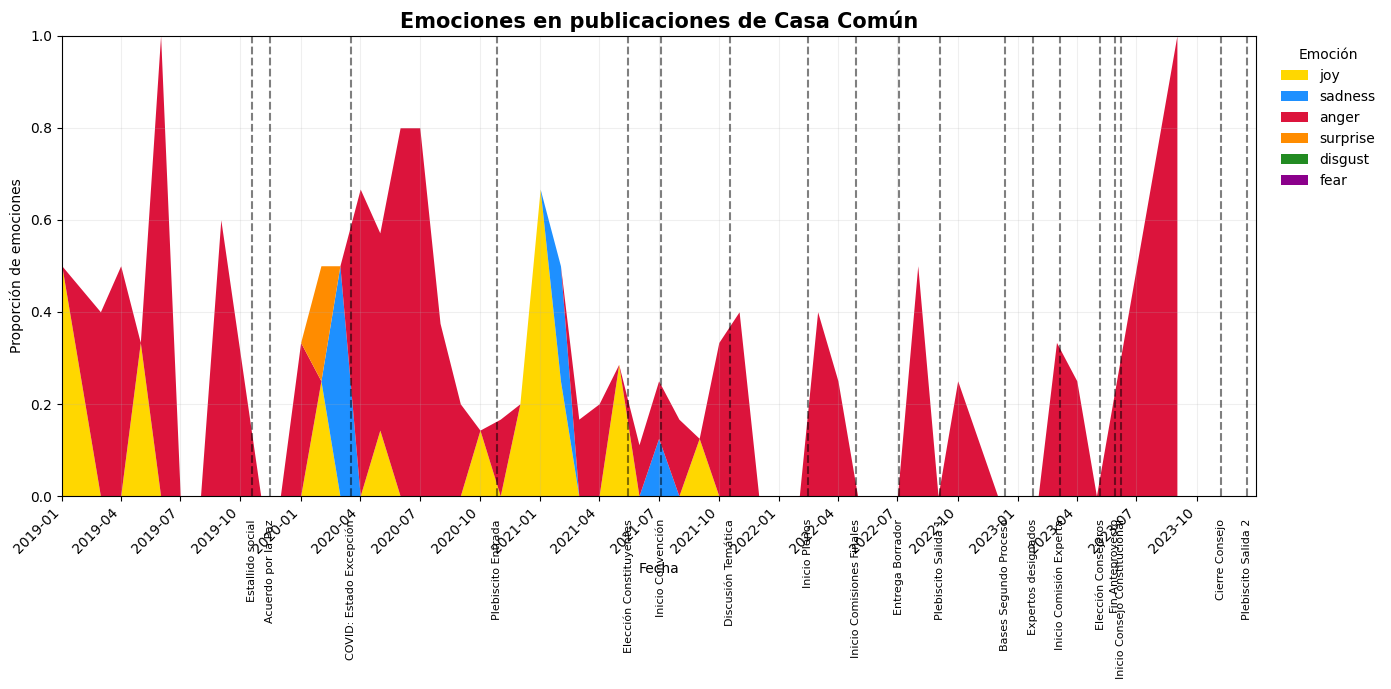

Procesando: Signos Uandes


Detectando emociones en Signos Uandes: 100%|██████████| 3612/3612 [01:41<00:00, 35.70it/s]


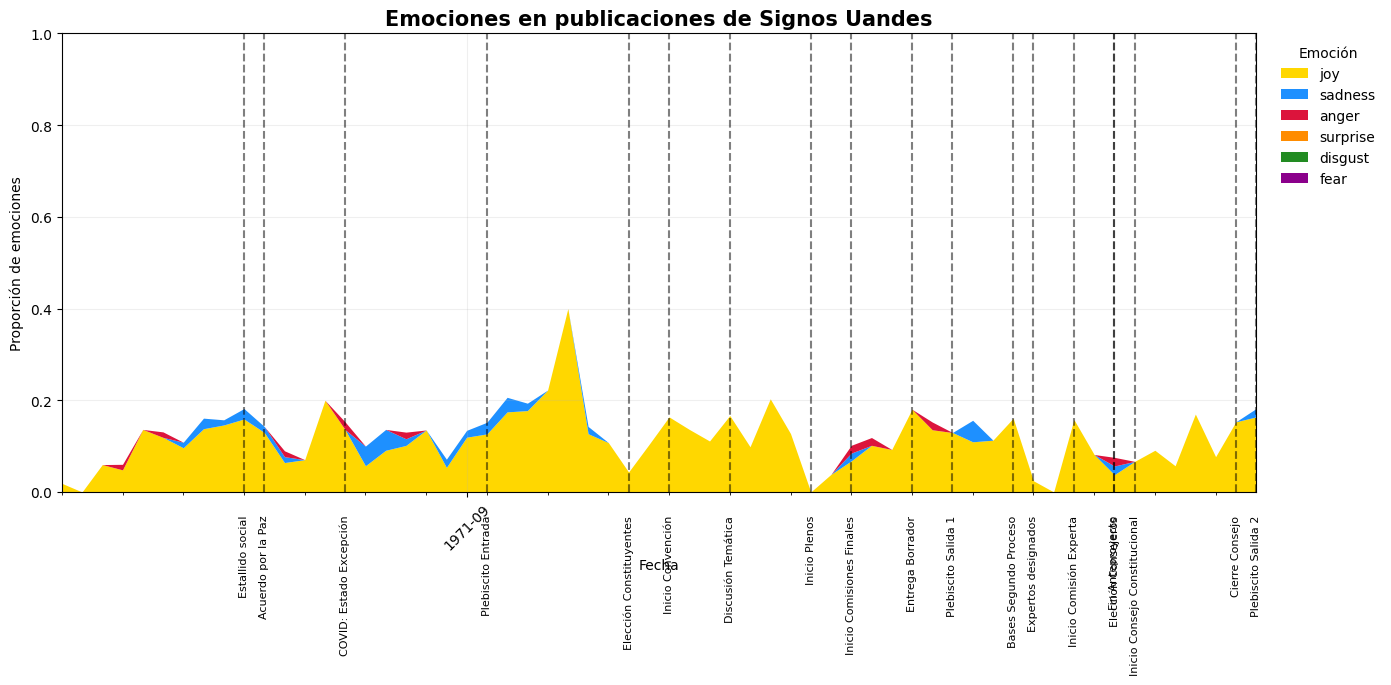

Procesando: Instituto Res Pública


Detectando emociones en Instituto Res Pública: 100%|██████████| 575/575 [00:29<00:00, 19.54it/s]


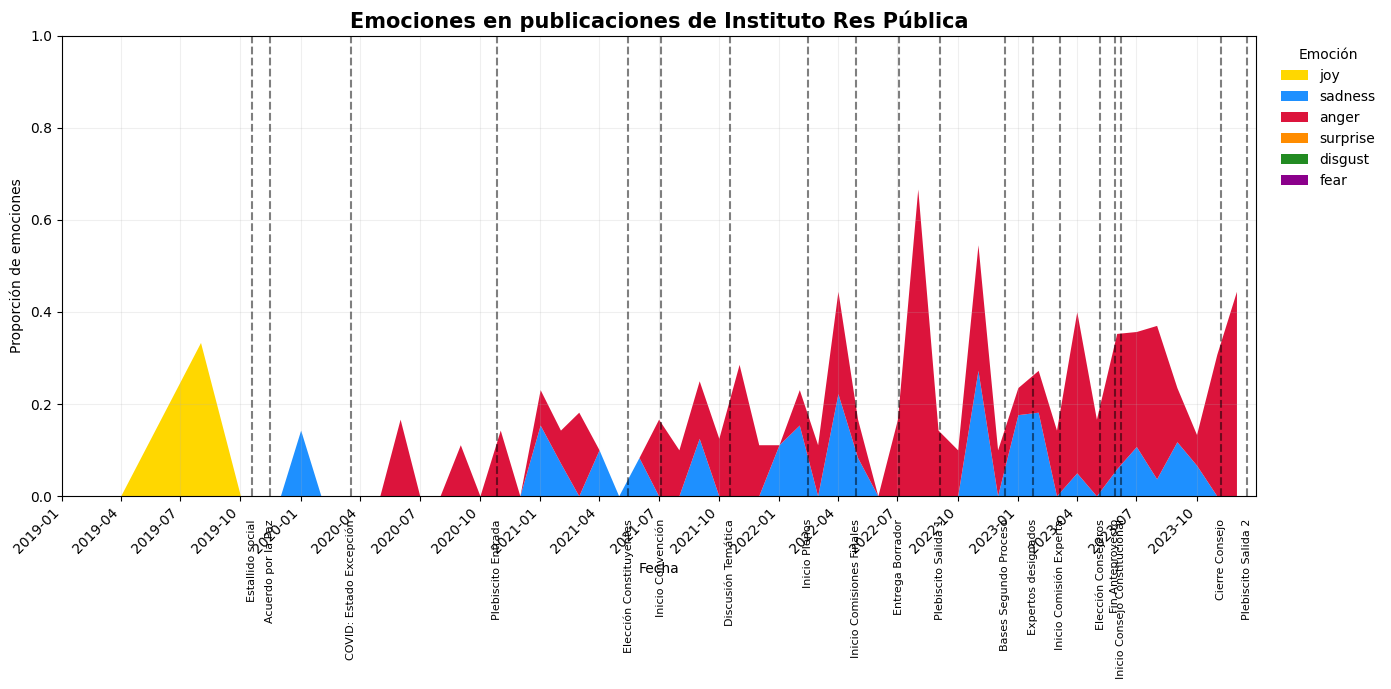

Procesando: Pivotes


Detectando emociones en Pivotes: 100%|██████████| 412/412 [00:13<00:00, 29.66it/s]


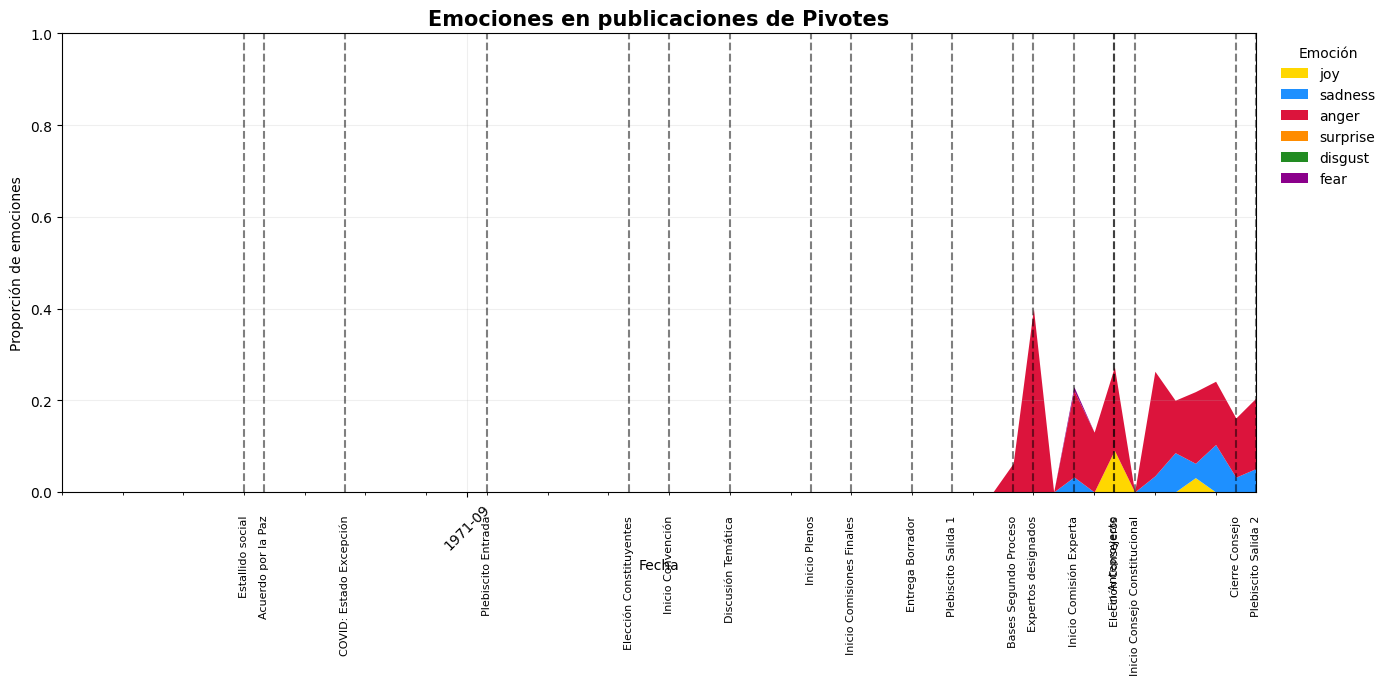

Procesando: Instituto Libertad


Detectando emociones en Instituto Libertad: 100%|██████████| 124/124 [00:02<00:00, 43.10it/s]


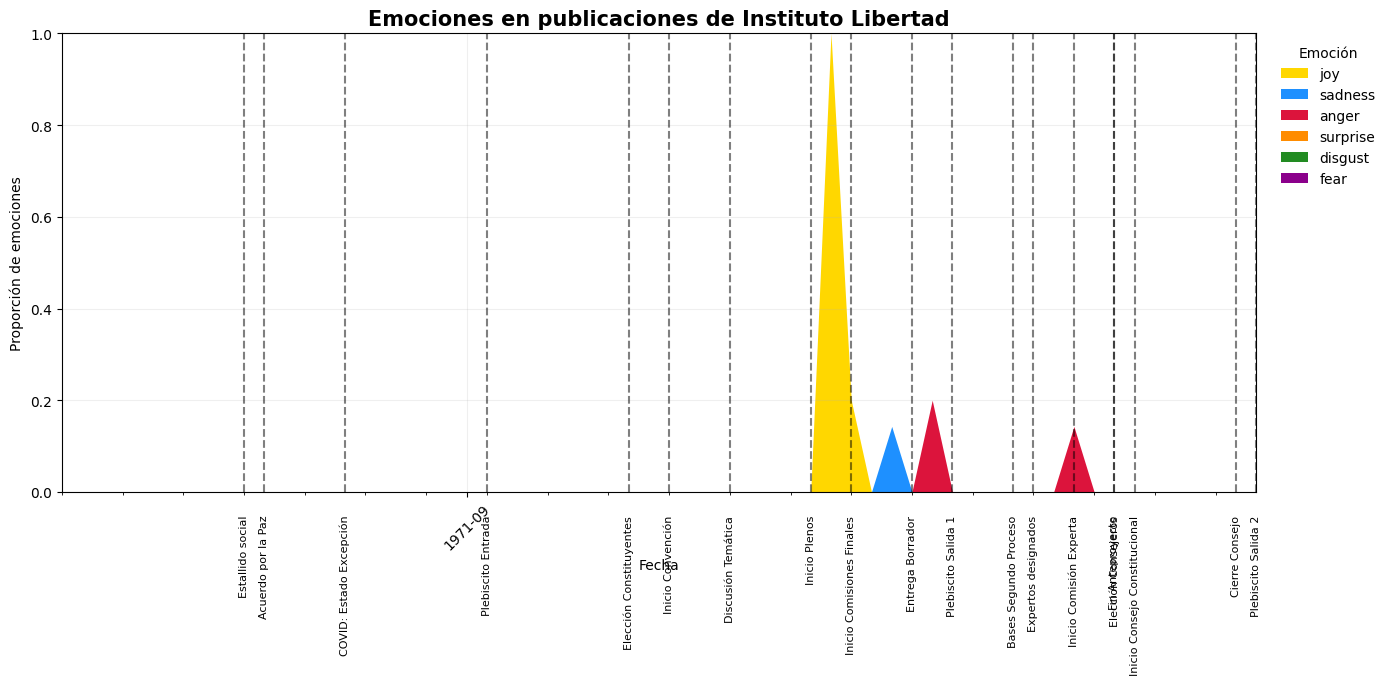

Procesando: Ideas Republicanas


Detectando emociones en Ideas Republicanas: 100%|██████████| 9/9 [00:00<00:00, 42.59it/s]


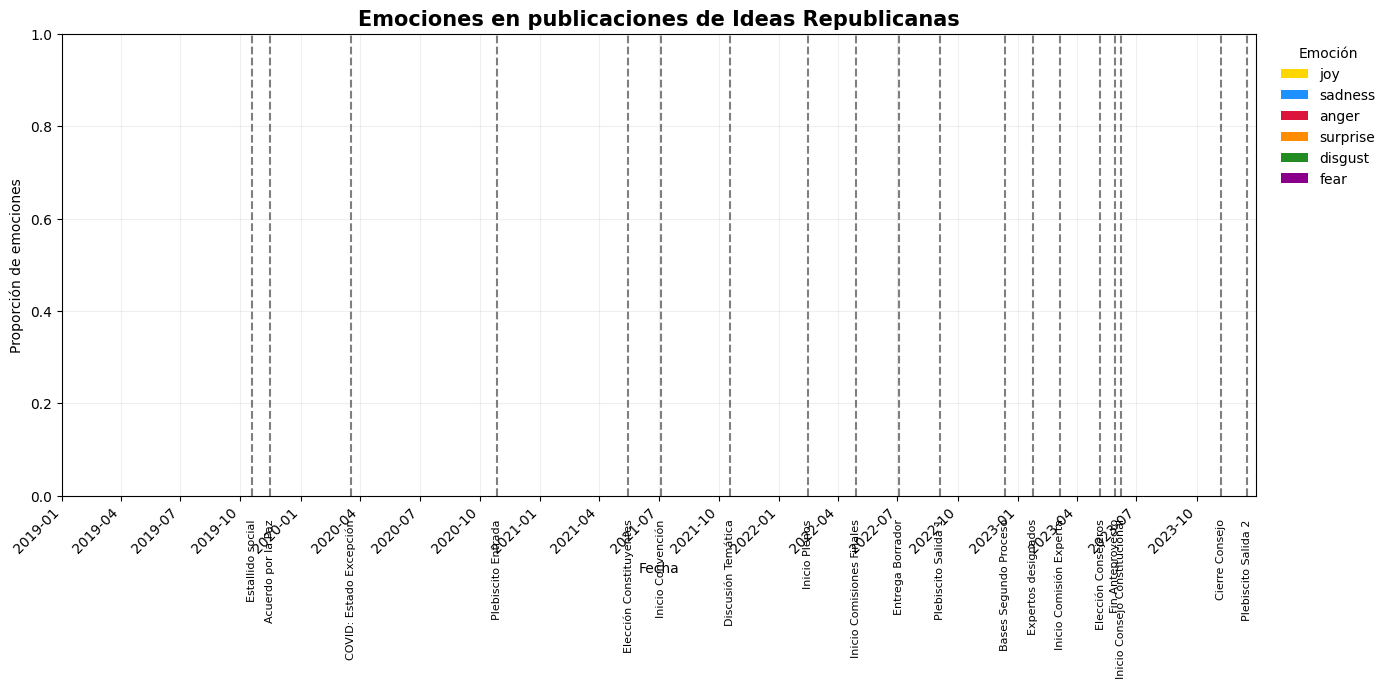

Procesando: Idea País


Detectando emociones en Idea País: 100%|██████████| 3/3 [00:00<00:00,  3.61it/s]


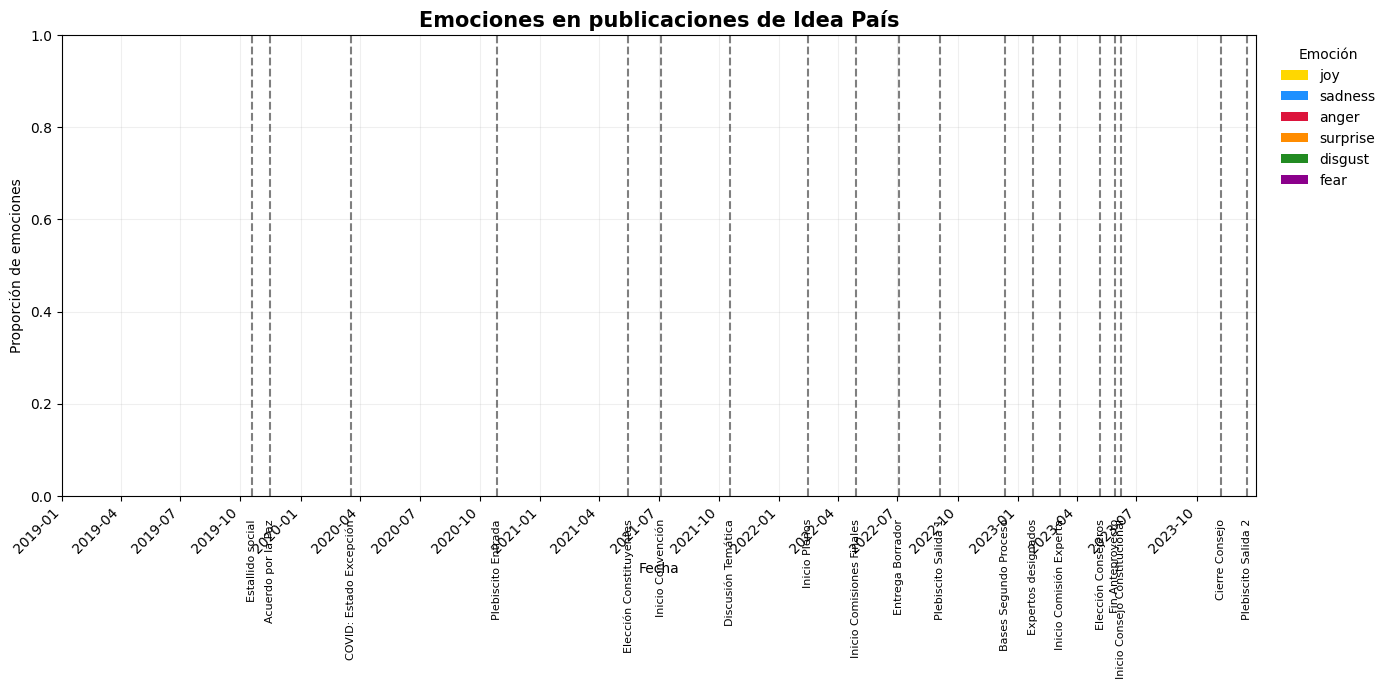

Procesando: Horizontal


Detectando emociones en Horizontal: 100%|██████████| 116/116 [00:02<00:00, 49.00it/s]


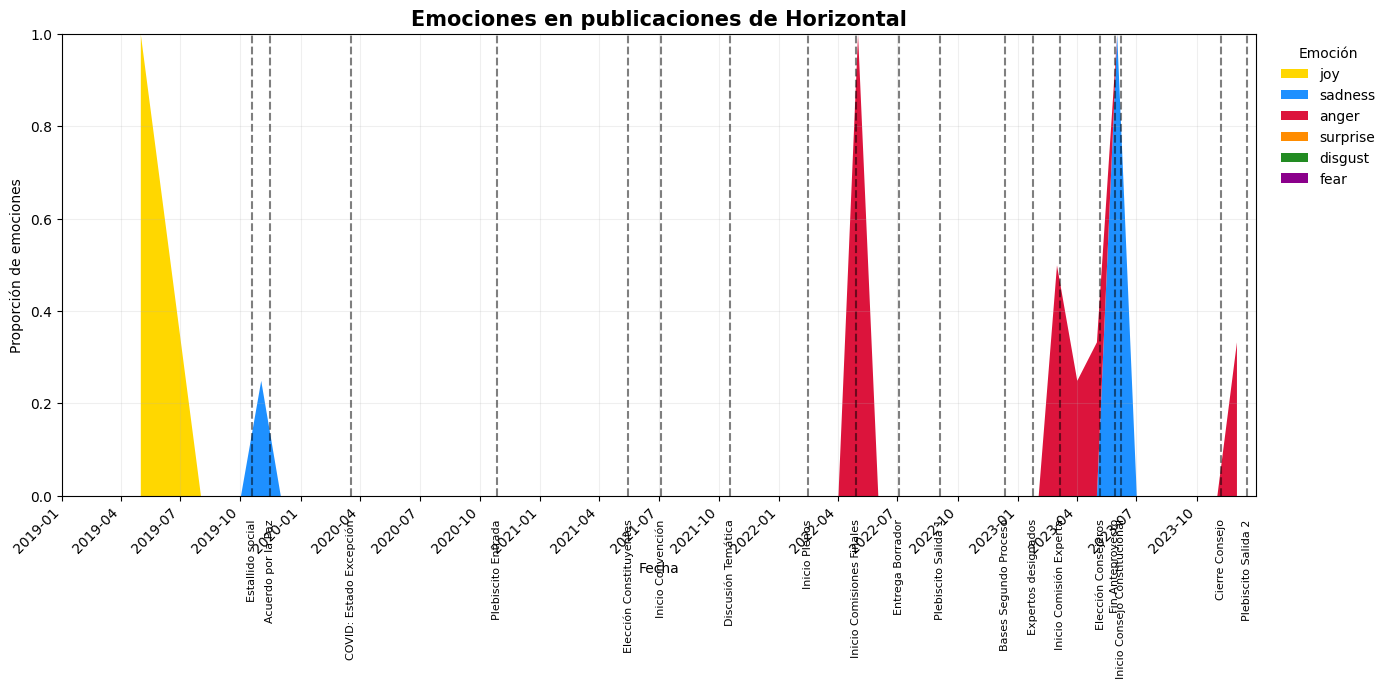

Procesando: Fundación Jaime Guzmán


Detectando emociones en Fundación Jaime Guzmán: 100%|██████████| 678/678 [00:20<00:00, 32.79it/s]


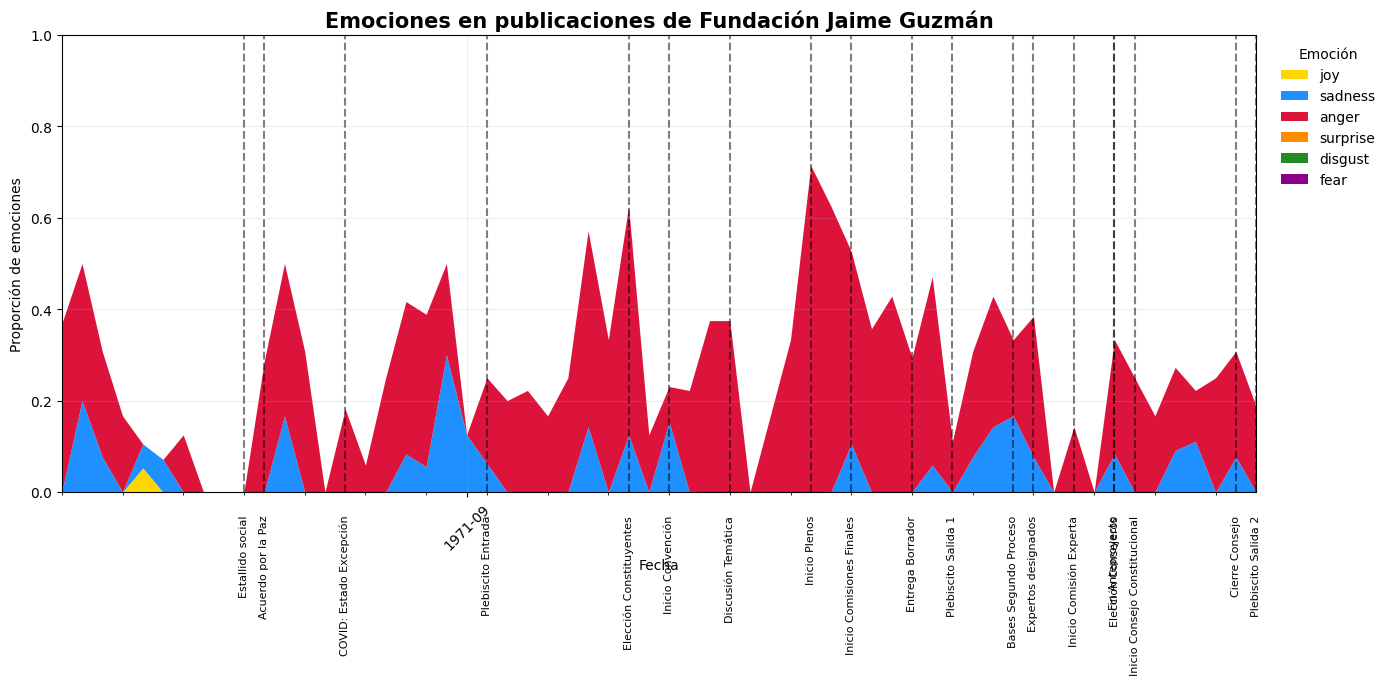

Procesando: CLAPES UC


Detectando emociones en CLAPES UC: 100%|██████████| 207/207 [00:06<00:00, 30.70it/s]


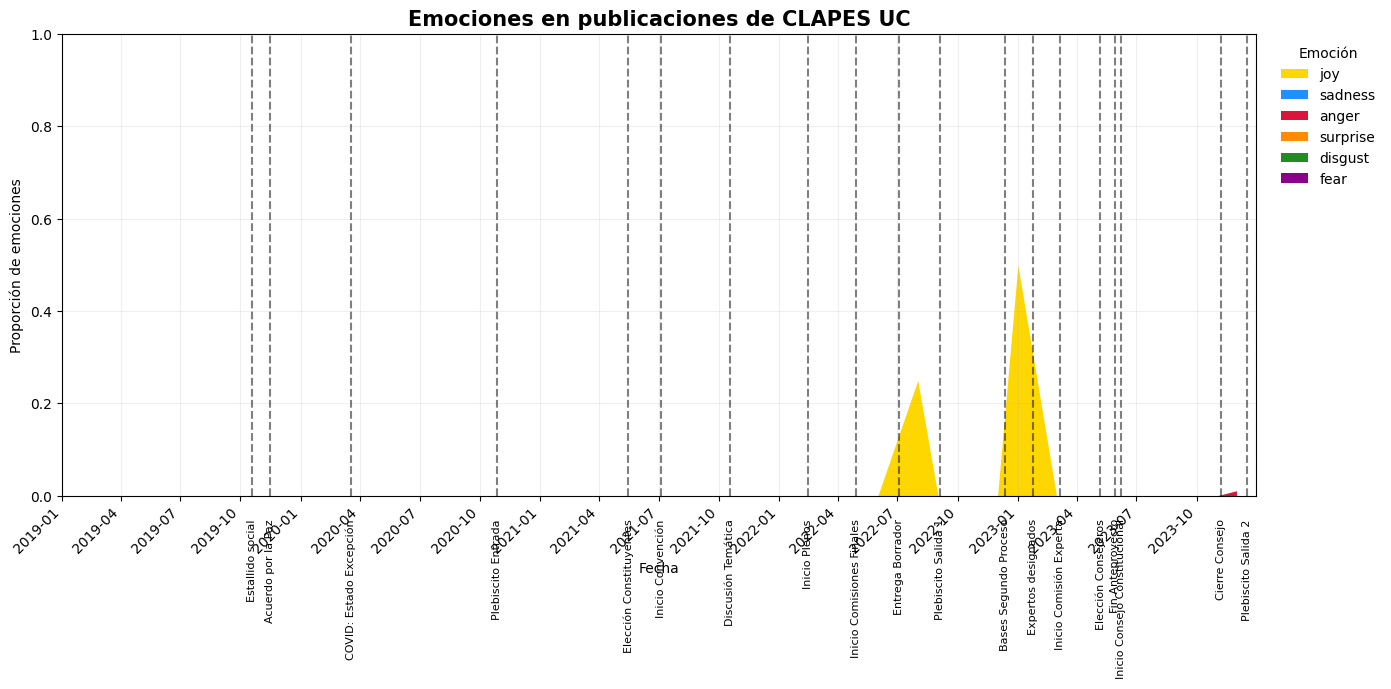

Procesando: FPP


Detectando emociones en FPP: 100%|██████████| 2586/2586 [01:59<00:00, 21.56it/s]


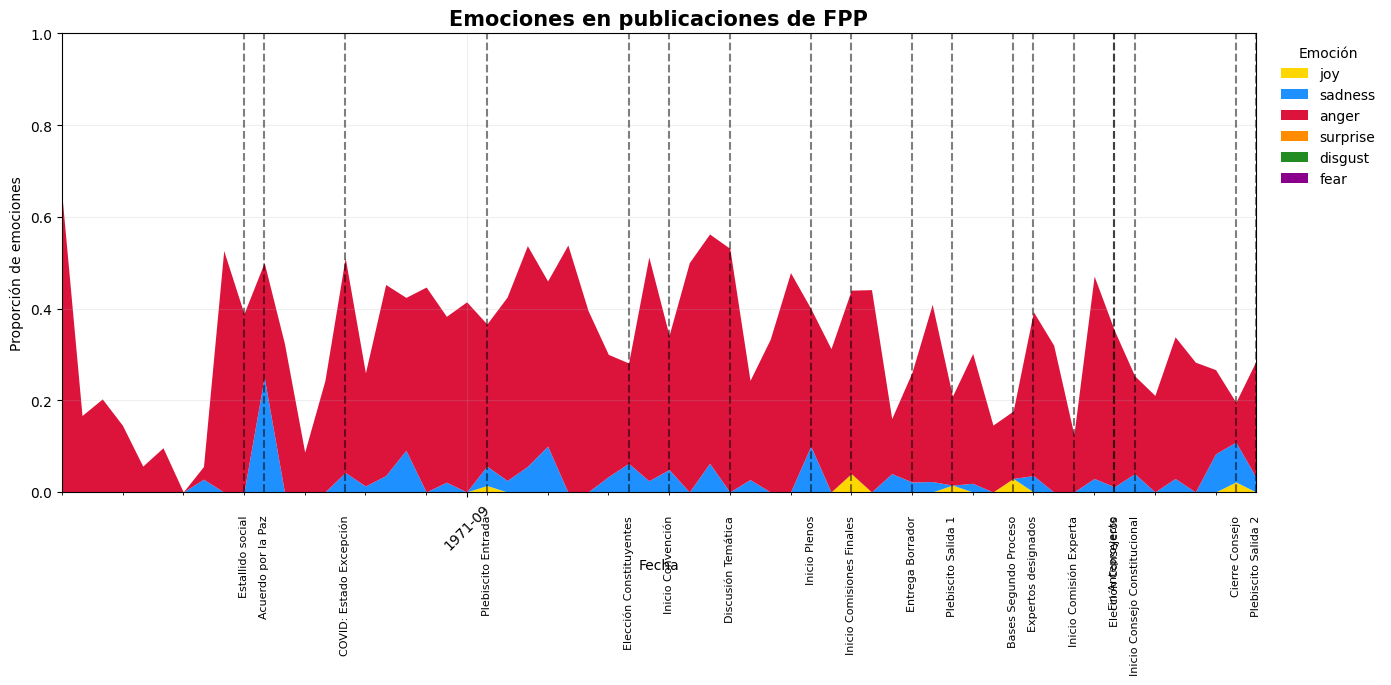

In [10]:

think_tanks = df["Think Tank"].unique()

for tt in think_tanks:
    print(f"Procesando: {tt}")
    df_tt = df[df["Think Tank"] == tt].copy()
    tqdm.pandas(desc=f"Detectando emociones en {tt}")
    df_tt["Emocion"] = df_tt["Texto"].progress_apply(detectar_emocion_larga)

    # Proporciones por mes
    emo_timeline = pd.crosstab(df_tt["FechaMes"], df_tt["Emocion"])
    emo_timeline = emo_timeline.div(emo_timeline.sum(axis=1), axis=0)
    emo_timeline = emo_timeline.reindex(columns=EMO_LABELS).fillna(0)
    emo_timeline_plot = emo_timeline[EMO_LABELS_PLOT]

    # Gráfico con hitos y sin "others"
    fig, ax = plt.subplots(figsize=(14, 7))
    emo_timeline_plot.plot(
        kind='area', stacked=True, ax=ax,
        color=[COLORS.get(e, "gray") for e in EMO_LABELS_PLOT], linewidth=0
    )

    for label, fecha in hitos:
        f = pd.to_datetime(fecha)
        if pd.Timestamp("2019-01-01") <= f <= pd.Timestamp("2023-12-31"):
            ax.axvline(f, color='black', linestyle='--', alpha=0.5)
            ax.text(f, -0.05, label, rotation=90, va='top', ha='center', fontsize=8, transform=ax.get_xaxis_transform())

    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.set_xlim([pd.Timestamp("2019-01-01"), pd.Timestamp("2023-12-31")])
    ax.set_title(f"Emociones en publicaciones de {tt}", fontsize=15, fontweight='bold')
    ax.set_ylabel("Proporción de emociones")
    ax.set_xlabel("Fecha")
    ax.set_ylim(0, 1)
    ax.grid(alpha=0.2)
    ax.legend(title='Emoción', bbox_to_anchor=(1.01, 1), loc='upper left', frameon=False)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


### Resultados Específicos por Think Tank

A continuación, se presentan los resultados del análisis de emociones para cada think tank, destacando las emociones predominantes y los patrones observados en sus publicaciones:

#### 1. **LyD (Libertad y Desarrollo)**
    - **Emociones predominantes**: Se observa una mayor proporción de **alegría** y **sorpresa** en períodos de estabilidad económica, mientras que **miedo** e **ira** aumentan en contextos de crisis política.
    - **Patrones destacados**: Durante el *Estallido Social* y la pandemia de COVID-19, las emociones negativas como **ira** y **miedo** fueron más frecuentes.

#### 2. **CEP (Centro de Estudios Públicos)**
    - **Emociones predominantes**: Predominan textos clasificados como "others", indicando un enfoque más neutral o técnico en sus publicaciones.
    - **Patrones destacados**: Las emociones detectadas son menos marcadas, reflejando un estilo analítico y objetivo.

#### 3. **Chile 21**
    - **Emociones predominantes**: **Ira** y **miedo** son recurrentes en períodos de debate constitucional y crisis social.
    - **Patrones destacados**: Se observa un aumento de **alegría** en momentos de avances políticos progresistas, como la elección de constituyentes.

#### 4. **Espacio Público**
    - **Emociones predominantes**: **Sorpresa** y **alegría** destacan en publicaciones relacionadas con propuestas de políticas públicas innovadoras.
    - **Patrones destacados**: Durante la pandemia, se incrementaron las emociones de **miedo** y **tristeza**, reflejando preocupación por la crisis sanitaria.

#### 5. **Fundación Sol**
    - **Emociones predominantes**: **Ira** y **tristeza** son frecuentes, especialmente en publicaciones relacionadas con desigualdad y derechos laborales.
    - **Patrones destacados**: Las emociones negativas aumentan en períodos de crisis económica y social.

#### 6. **IES (Instituto de Estudios de la Sociedad)**
    - **Emociones predominantes**: **Sorpresa** y **alegría** aparecen en publicaciones sobre valores culturales y sociales.
    - **Patrones destacados**: Las emociones son más equilibradas, con menor presencia de **ira** y **miedo**.

#### 7. **Nodo XXI**
    - **Emociones predominantes**: **Ira** y **miedo** son recurrentes en publicaciones críticas hacia políticas gubernamentales.
    - **Patrones destacados**: Aumentos significativos de emociones negativas durante el *Estallido Social*.

#### 8. **FPP (Fundación para el Progreso)**
    - **Emociones predominantes**: **Ira** es la emoción más frecuente, especialmente en publicaciones críticas hacia políticas progresistas.
    - **Patrones destacados**: Durante el debate constitucional, se observa un incremento de **miedo** y **tristeza**.

#### 9. **Horizonte Ciudadano**
    - **Emociones predominantes**: **Alegría** y **sorpresa** destacan en publicaciones relacionadas con avances sociales y políticos.
    - **Patrones destacados**: Las emociones negativas son menos frecuentes, reflejando un enfoque optimista.

#### 10. **Fundación Jaime Guzmán**
    - **Emociones predominantes**: **Ira** y **miedo** son recurrentes en publicaciones relacionadas con la defensa de valores conservadores.
    - **Patrones destacados**: Incremento de emociones negativas durante períodos de cambios sociales significativos.

### Conclusión
Cada think tank presenta un perfil emocional único en sus publicaciones, influenciado por su orientación política, enfoque temático y los eventos históricos del período analizado. Estos resultados permiten comprender cómo las emociones son utilizadas como herramienta de comunicación y reflejan las prioridades de cada institución.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17432 entries, 205 to 31640
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ID                    17432 non-null  int64         
 1   Think Tank            17432 non-null  object        
 2   Tipo de Think Tank    17432 non-null  object        
 3   Orientación Política  17432 non-null  object        
 4   Autor                 8390 non-null   object        
 5   Título                17432 non-null  object        
 6   Medio                 2498 non-null   object        
 7   Corpus                17432 non-null  object        
 8   Producto              10353 non-null  object        
 9   Enlace                17432 non-null  object        
 10  CorpusPDF             17432 non-null  object        
 11  FechaPublicacion      17432 non-null  datetime64[ns]
 12  Año                   17432 non-null  float64       
 13  Mes                

### ¿Qué es un modelo BERT?

BERT (Bidirectional Encoder Representations from Transformers) es un modelo de lenguaje desarrollado por Google basado en la arquitectura de Transformers. Es ampliamente utilizado en tareas de procesamiento de lenguaje natural (NLP) debido a su capacidad para comprender el contexto de las palabras en ambos sentidos (izquierda y derecha) dentro de una oración.

### Características principales de BERT:
1. **Preentrenamiento bidireccional**:
    - A diferencia de modelos unidireccionales, BERT analiza el contexto de una palabra considerando tanto las palabras anteriores como las posteriores en una oración.

2. **Tareas de preentrenamiento**:
    - **Máscara de palabras (Masked Language Model - MLM)**: Durante el entrenamiento, algunas palabras se ocultan (enmascaran) y el modelo aprende a predecirlas basándose en el contexto.
    - **Predicción de la siguiente oración (Next Sentence Prediction - NSP)**: El modelo aprende relaciones entre pares de oraciones, lo que es útil para tareas como clasificación de texto o preguntas y respuestas.

3. **Transferencia de aprendizaje**:
    - BERT se entrena en grandes corpus de texto (como Wikipedia) y luego se ajusta (fine-tuning) para tareas específicas, como análisis de emociones, clasificación de texto, o traducción.

### En este caso:
El modelo BERT utilizado, `finiteautomata/beto-emotion-analysis`, es una variante de BERT llamada BETO, que está preentrenada específicamente en español. Este modelo ha sido ajustado para la tarea de análisis de emociones, permitiendo clasificar textos en categorías emocionales como "alegría", "tristeza", "ira", entre otras.

### Ventajas de usar BERT:
- Captura el contexto completo de las palabras.
- Es altamente efectivo para tareas de clasificación, extracción de información y generación de texto.
- Puede adaptarse fácilmente a diferentes idiomas y dominios mediante fine-tuning.


